## AE3

In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import f1_score

In [519]:
# struktura sieci neuronowej

class NeuralNetwork:
    """
    Implementation of multi layer perceptron

    Attributes
    -----------
    model_type : str
        model type, regressor or classifier
    layers : List
        list of layer sizes
    num_layers : int
        number of layers
    init_function : func
        
    """
    
    def __init__(self, layers, X, y, initalization='xavier', model_type='regression', resize=False, weights=None, biases=None, activations=None):
        """
        activations - list of available functions: 'sigmoid', 'linear', 'tanh', 'relu', 'softmax' ('softmax' can be used only on the last layer)
        initialization - available types: 'xavier', 'he', 'uniform'
        model_type - available types: 'regression', 'classification'
        """        
        self.layers = layers
        self.num_layers = len(layers)
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        self.X = X
        self.y = y
        
        initialization_functions = {
            'xavier': self.xavier_init,
            'he': self.he_init,
            'uniform': self.uniform_init
        }
        self.init_function = initialization_functions.get(initalization)
        
        assert model_type in ['regression', 'classification']
        self.model_type = model_type
        
        if weights is None:
            self.weights = [self.init_function(layers[i-1], layers[i]) for i in range(1, self.num_layers)]
        else:
            self.weights = weights
        
        if biases is None:
            self.biases = [self.init_function(layers[i]) for i in range(1, self.num_layers)]
        else:
            self.biases = biases
        
        if activations is None:
            if self.model_type == 'regression':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['linear']
            elif self.model_type == 'classification':
                self.activations = ['sigmoid' for i in range(1, self.num_layers - 1)] + ['softmax']
        else:
            self.activations = activations
        
        activation_functions = {
            'sigmoid': self._sigmoid,
            'linear': self._linear,
            'softmax': self._softmax,
            'tanh': self._tanh,
            'relu': self._relu
        }
        self.activation_funcs = list(map(lambda x: activation_functions.get(x), self.activations))
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _linear(self, z):
        return z
    
    def _tanh(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
    def _relu(self, z):
        return np.maximum(z, 0)
    
    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / exp_z.sum(axis=1, keepdims=True)
    
    def tanh_derivative(self, a):
        """calculates tanh'(z) where a = tanh(z)"""
        return 1 - (a ** 2)
    
    def sigmoid_derivative(self, a):
        """calculates sigm'(z) where a = sigm(z)"""
        return a * (1-a)
    
    def relu_derivative(self, z):
        return np.maximum(0, np.sign(z))
    
    def xavier_init(self, n_in, n_out=None):
        if n_out is None:
            n_out = n_in
            variance = 1 / n_out
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_out)
        variance = 2 / (n_in + n_out)
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
        
    def he_init(self, n_in, n_out=None):
        if n_out is None:
            variance = 2 / n_in
            stddev = np.sqrt(variance)
            return np.random.normal(0, stddev, n_in)
        variance = 2 / n_in
        stddev = np.sqrt(variance)
        return np.random.normal(0, stddev, (n_in, n_out))
    
    def zeros_init(self, n_in, n_out=None):
        if n_out is None:
            return np.zeros(n_in)
        return np.zeros((n_in, n_out))
    
    def uniform_init(self, n_in, n_out=None):
        if n_out is None:
            return np.random.uniform(0, 1, n_in)
        return np.random.uniform(0, 1, (n_in, n_out))
    
    def feedforward(self, a, return_activations=False):
        if return_activations:
            activations = [a]
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
                activations.append(a)
            return activations
        else:
            for w, b, func in zip(self.weights, self.biases, self.activation_funcs):
                z = np.dot(a, w) + b
                a = func(z)
            return a
    
    def predict(self, X, label=False):
        """ if to use label_predictions function """
        if label:
            return label_predictions(self.feedforward(X))
        else:
            return self.feedforward(X)
    
    def mse(self, X, y, resize=False, denormalize=None):
        """
        first predictions are made, then denormalized and then mse is calculated
        
        denormalize - a tuple (mean, std)
        """
        if resize:
            X = X.to_numpy().reshape(-1, 1)
            y = y.to_numpy().reshape(-1, 1)
        predictions = self.predict(X)
        if denormalize:
            predictions = destandardize_data(predictions, denormalize)
        return np.mean((predictions - y) ** 2)
    
    def f1_score(self, X, y_true, average='weighted'):
        """
        calculates f1 score. 
        y_true : 2 dimensional array with probabilities
        average: 'weighted', 'macro'
        """
        predictions = self.predict(X)
        y_pred = label_predictions(predictions)
        y_true = label_predictions(y_true)
        f1 = f1_score(y_true, y_pred, average='weighted')
        return f1

    def cross_entropy(self, X, y):
        """ Calculates cross entropy loss """
        predictions = self.predict(X)
        epsilon = 1e-9  # Small constant to avoid taking the logarithm of zero
        return -np.mean(np.sum(y * np.log(predictions + epsilon), axis=1))
    
    def loss(self, X, y, resize=False, denormalize=None, test=False):
        """ returns appriopriate loss """
        if self.model_type == 'regression':
            return self.mse(X, y, resize=resize, denormalize=denormalize)
        elif self.model_type == 'classification':
            if test:
                return self.f1_score(X, y)
            else:
                return self.cross_entropy(X, y)

    def fitness(self, test=False):
        return self.loss(self.X, self.y, test=test)
    
    def flatten_weights(self):
        """ flattens weights and biases """
        flat = []
        for weights, biases in zip(self.weights, self.biases):
            flat.extend(weights.flatten())
            flat.extend(biases.flatten())
        return flat
    
    def unflatten_weights(self, flat):
        """ unflattens flat array of weights and biases """
        weights_full = []
        biases_full = []
        
        for weights, biases in zip(self.weights, self.biases):
            w_len = len(weights.flatten())
            b_len = len(biases.flatten())
            
            w_flat = flat[:w_len]
            w_unflat = np.array(w_flat).reshape(weights.shape)
            weights_full.append(w_unflat)
            flat = flat[w_len:]
            
            b_flat = flat[:b_len]
            b_unflat = np.array(b_flat).reshape(biases.shape)
            biases_full.append(b_unflat)
            flat = flat[b_len:]
        
        return weights_full, biases_full
    
def standardize_data(X):
    """
    returns:
    X_new - standardized X
    a tuple (mean, std) - normal distribution parameters from X for destandarizing
    """
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_new = (X - mean) / std
    return X_new, (mean, std)

def destandardize_data(X, parameters):
    """parameters: a tuple (mean, std)"""
    return X * parameters[1] + parameters[0]


def label_predictions(y_pred, class_order=None):
    """
    y_pred : 2 dimensional array
    class_order : default [..., 2, 1, 0]
    """
    if class_order is None:
        class_order = np.array(range(len(y_pred[0])))
    max_indices = np.argmax(y_pred, axis=1)
    return class_order[max_indices]

def one_hot_encode(y):
    """ y : pd.Series """
    return pd.get_dummies(y, dtype=int).to_numpy()

def decode_array(array):
    """ decodes one hot encoded array """
    decoded_indices = np.argmax(array, axis=1)
    return decoded_indices.tolist()

def mse(y_true, y_pred):
    """ calculated mse """
    return np.mean((y_pred - y_true) ** 2)

def cross_entropy(y_true, y_pred):
    """ calculates cross entropy loss, y_true and y_pred should be 2-dimensional """
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

In [520]:
class EvoAlg:
    
    def __init__(self, X, y, layers, model_type, resize=False, population_size=20, generations=100):
        self.default_mlp = NeuralNetwork(layers=layers, X=X, y=y, model_type=model_type, resize=resize)
        self.X = X
        self.y = y
        self.layers = layers
        self.model_type = model_type
        self.dimension = len(self.default_mlp.flatten_weights())
        self.population_size = population_size
        self.population = np.array([NeuralNetwork(layers=layers, X=X, y=y, model_type=model_type, resize=resize) for i in range(population_size)])
        self.generations = generations
        self.mutation_rate = None
        self.crossover_rate = None
    
    def point_crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.dimension)
            
            parent1_flat = parent1.flatten_weights()
            parent2_flat = parent2.flatten_weights()
            
            child1_flat = np.concatenate((parent1_flat[:point], parent2_flat[point:]))
            child2_flat = np.concatenate((parent2_flat[:point], parent1_flat[point:]))

            child1_weights, child1_biases = parent1.unflatten_weights(child1_flat)
            child2_weights, child2_biases = parent2.unflatten_weights(child2_flat)

            child1 = deepcopy(self.default_mlp)
            child2 = deepcopy(self.default_mlp)
            
            child1.weights = child1_weights
            child1.biases = child1_biases
            child2.weights = child2_weights
            child2.biases = child2_biases
            
            return child1, child2
        return parent1, parent2
    
    def gaussian_mutation(self, individual):
        if np.random.rand() < self.mutation_rate:
            
            ind_flat = np.array(individual.flatten_weights())

            # standardize
            ind_flat_norm, norm_params = standardize_data(ind_flat)
            
            # ind_flat_norm += np.random.normal(0, 1, self.dimension)

            num_indices = np.random.randint(1, self.dimension + 1)
            indices_to_modify = np.random.choice(self.dimension, num_indices, replace=False)
            random_values = np.random.normal(0, 1, num_indices)
            ind_flat_norm[indices_to_modify] += random_values
            
            ind_flat = destandardize_data(ind_flat_norm, norm_params)
            
            ind_weights, ind_biases = individual.unflatten_weights(ind_flat)
            new_ind = deepcopy(individual)
            new_ind.weights = ind_weights
            new_ind.biases = ind_biases
            return new_ind
            
        return individual
    
    def evaluation(self, population):
        return np.array([ind.fitness() for ind in population])
    
    def wheel_selection(self, population, size=None):
        if size is None:
            size = self.population_size
        fitness = self.evaluation(population) + 0.01
        fitness_inverted = 1 / fitness
        probabilities = fitness_inverted / np.sum(fitness_inverted)
        selected_indices = np.random.choice(len(population), size, p=probabilities)
        return population[selected_indices]
    
    def choose_random_individuals(self, population_size, n):
        individuals = self.population[np.random.choice(population_size, n, replace=False)]
        if n == 1:
            return individuals[0]
        else:
            return individuals
    
    def train(self, mutation_rate=0.7, crossover_rate=0.7, mute_print=False):
        
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        
        best_fitness_history = []
        
        for generation in range(self.generations):

            new_population = []
            while len(new_population) < self.population_size:
                parent1, parent2 = self.choose_random_individuals(self.population_size, 2)
                child1, child2 = self.point_crossover(parent1, parent2)
                new_population.extend([child1, child2])
            population = np.vstack([self.population, np.array(new_population)]).flatten()
            
            new_population = []
            for i, parent in enumerate(population):
                child = self.gaussian_mutation(parent)
                new_population.extend([child])
            population = np.vstack([population, np.array(new_population)]).flatten()
            
            fitness = self.evaluation(population)

            num_top_individuals = max(1, int(0.1 * len(population)))
            sorted_indices = np.argsort(fitness)
            top_individuals = population[sorted_indices[:num_top_individuals]]
        
            remaining_population = self.wheel_selection(population, size=self.population_size - num_top_individuals)
        
            self.population = np.concatenate((top_individuals, remaining_population))

            # self.population = self.wheel_selection(population, size=self.population_size)
        
            fitness = self.evaluation(self.population)
            best_individual = self.population[np.argmin(fitness)]
            best_fitness = best_individual.fitness()
            
            best_fitness_history.append(best_fitness)
            
            if not mute_print:
                if (generation + 1) % 5 == 0:
                    print(f"Generation {generation+1}: best individual: {best_individual}, fitness: {best_fitness}")
        
        if mute_print:
            print(f"Best individual: {best_individual}, fitness: {best_fitness}")

        history = History(best_fitness_history)
        
        return {'history': history,
                'best_individual': best_individual,
                'best_fitness': best_fitness}
    
class History:
    
    def __init__(self, fitness):
        self.fitness = fitness
        self.generations = list(range(len(fitness)))
    
    def plot_history(self):
        plt.plot(self.generations, self.fitness)
        plt.ylabel("Best individual fitness")
        plt.xlabel("Generation")
        plt.title("Evolution history")
        plt.show()

## Multimodal

In [277]:
def plot_multimodal(data, network):    
    preds_modal = network.predict(data['x'].to_numpy().reshape(-1,1))
    plt.scatter(data['x'], data['y'])
    plt.scatter(data['x'], preds_modal, s=5)
    print('MSE:', network.mse(data['x'], data['y'], resize=True))
    plt.show()

In [10]:
multimodal = pd.read_csv("dane/multimodal-large-training.csv", index_col=0).reset_index()

### Experiments

### 1, 10, 1

In [267]:
ae = EvoAlg(X=multimodal['x'], y=multimodal['y'], layers=[1,10,1], model_type='regression',
            population_size=30, generations=200)

In [269]:
results = ae.train()

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D56E464A50>, fitness: 1940.8913011059572
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D56E464A50>, fitness: 1940.8913011059572
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D56E464A50>, fitness: 1940.8913011059572
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D56E4E5650>, fitness: 1914.8364652377047
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D56E45C750>, fitness: 1904.037099502746
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D56E45C750>, fitness: 1904.037099502746
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D56E45C750>, fitness: 1904.037099502746
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D56E45C750>, fitness: 1904.037099502746
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D56E45C750>

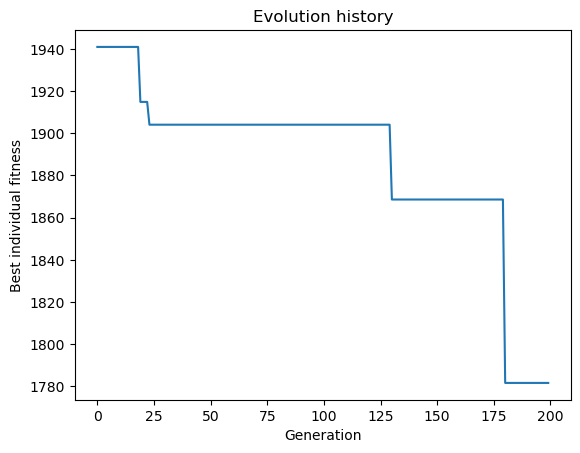

In [274]:
results['history'].plot_history()

MSE: 1781.6702740888227


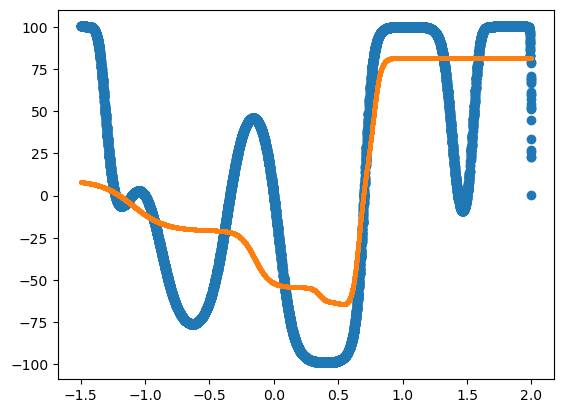

In [278]:
plot_multimodal(multimodal, results['best_individual'])

In [285]:
fitnesses = []
for i in range(5):
    print(f'iteration {i}')
    ae = EvoAlg(X=multimodal['x'], y=multimodal['y'], layers=[1,10,1], model_type='regression',
            population_size=30, generations=150)
    result_i = ae.train(mute_print=True)
    fitnesses.append(result_i['best_fitness'])
print(np.mean(fitnesses))
print(np.std(fitnesses))

iteration 0
Best individual: <__main__.NeuralNetwork object at 0x000001D574F1F210>, fitness: 1809.8723751718223
iteration 1
Best individual: <__main__.NeuralNetwork object at 0x000001D574ED3550>, fitness: 2658.5107600159604
iteration 2
Best individual: <__main__.NeuralNetwork object at 0x000001D574EFA710>, fitness: 2393.8485478267185
iteration 3
Best individual: <__main__.NeuralNetwork object at 0x000001D574EFB3D0>, fitness: 1638.7404126070971
iteration 4
Best individual: <__main__.NeuralNetwork object at 0x000001D574F1E950>, fitness: 2377.922137269086
2175.778846578137
385.67971950945


### 1, 10, 10, 1

In [283]:
ae = EvoAlg(X=multimodal['x'], y=multimodal['y'], layers=[1,10,10,1], model_type='regression',
            population_size=30, generations=200)

In [284]:
results = ae.train()

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D574EAD590>, fitness: 5250.804148261605
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D574EBE850>, fitness: 5196.724293205077
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D574EC9750>, fitness: 5076.741484790434
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D574ED6DD0>, fitness: 4996.289564812076
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D574EE1090>, fitness: 4716.074172095456
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D574ED50D0>, fitness: 4397.280616271718
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D574ED2410>, fitness: 4074.420828540539
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D574EBEB10>, fitness: 4009.592650244163
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D574EAACD0>, fi

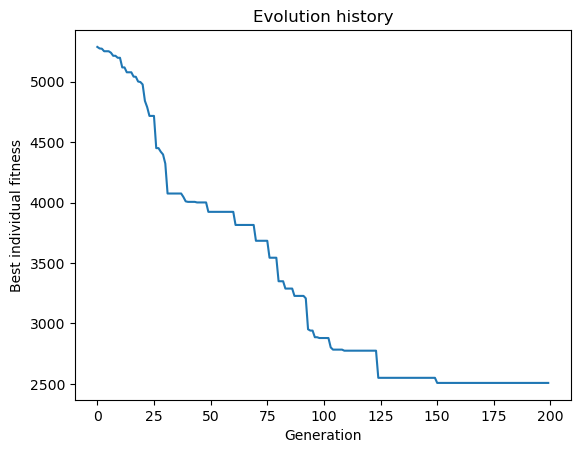

In [287]:
results['history'].plot_history()

### 1, 5, 5, 1

In [292]:
ae = EvoAlg(X=multimodal['x'], y=multimodal['y'], layers=[1,5,5,1], model_type='regression', population_size=20, generations=150)

In [290]:
res_3 = ae.train()

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D575167490>, fitness: 5253.079997907071
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D575142D90>, fitness: 5161.7486497157715
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D5750EB5D0>, fitness: 5097.568034226208
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D5750E9C90>, fitness: 5003.068150885805
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D574F3C590>, fitness: 4886.235442492996
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D57514D0D0>, fitness: 4871.035053791921
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D575166810>, fitness: 4788.415991200017
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D574EF9C10>, fitness: 4453.927511794107
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D57514CE10>, f

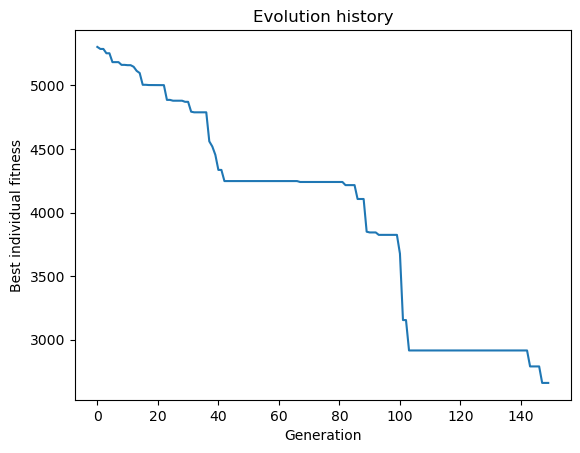

In [294]:
res_3['history'].plot_history()

In [295]:
fitnesses = []
for i in range(5):
    print(f'iteration {i}')
    ae = EvoAlg(X=multimodal['x'], y=multimodal['y'], layers=[1,5,5,1], model_type='regression',
            population_size=30, generations=150)
    result_i = ae.train(mute_print=True)
    fitnesses.append(result_i['best_fitness'])
print(np.mean(fitnesses))
print(np.std(fitnesses))

iteration 0
Best individual: <__main__.NeuralNetwork object at 0x000001D5763D8710>, fitness: 2179.824816991905
iteration 1
Best individual: <__main__.NeuralNetwork object at 0x000001D5764F3A50>, fitness: 2885.793818898432
iteration 2
Best individual: <__main__.NeuralNetwork object at 0x000001D57639C110>, fitness: 2640.40728196424
iteration 3
Best individual: <__main__.NeuralNetwork object at 0x000001D576393190>, fitness: 2177.3688284727914
iteration 4
Best individual: <__main__.NeuralNetwork object at 0x000001D57A58B590>, fitness: 2551.889785747962
2487.0569064150664
274.5938920265109


## MPG

In [ ]:
column_names = [
    "mpg",           # continuous
    "cylinders",     # multi-valued discrete
    "displacement",  # continuous
    "horsepower",    # continuous
    "weight",        # continuous
    "acceleration",  # continuous
    "model year",    # multi-valued discrete
    "origin",        # multi-valued discrete
    "car name"       # string (unique for each instance)
]

In [310]:
auto_mpg = fetch_ucirepo(id=9) 

In [339]:
mpg = auto_mpg.data.features
mpg_y = auto_mpg.data.targets
mpg['y'] = mpg_y.copy()
mpg.dropna(inplace=True)
mpg_X = mpg.drop(['y'], axis=1).to_numpy()
mpg_y = mpg['y'].copy().to_numpy()

C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\4038589600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpg['y'] = mpg_y.copy()
C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\4038589600.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mpg.dropna(inplace=True)


### Experiments

#### 7,5,1

In [340]:
ae = EvoAlg(X=mpg_X, y=mpg_y, layers=[7,5,1], model_type='regression', resize=False, population_size=20, generations=150)

In [341]:
res_mpg = ae.train()

C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\2194875051.py:71: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D5082A1590>, fitness: 247.48968075151714
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D508300490>, fitness: 62.46939256643181
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D5082596D0>, fitness: 60.76296849675888
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D5082596D0>, fitness: 60.76296849675888
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D508345C10>, fitness: 60.762747901279866
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D508345C10>, fitness: 60.762747901279866
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D508345C10>, fitness: 60.762747901279866
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D508345C10>, fitness: 60.762747901279866
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D508345C10

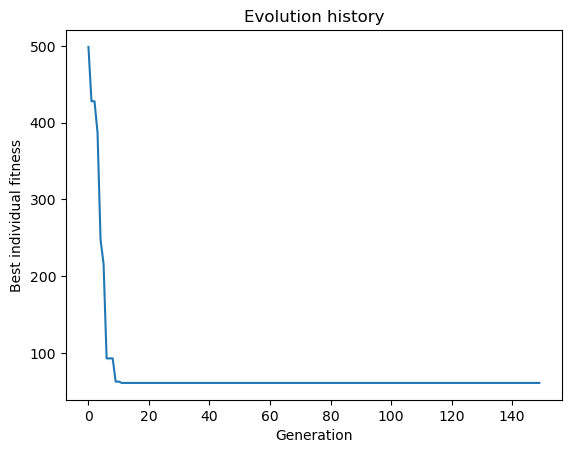

In [342]:
res_mpg['history'].plot_history()

#### 7, 10, 1

In [344]:
ae = EvoAlg(X=mpg_X, y=mpg_y, layers=[7,10,1], model_type='regression', resize=False, population_size=40, generations=200)
res_mpg2 = ae.train()

C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\2194875051.py:71: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D50827E0D0>, fitness: 283.08534742763567
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D50839A210>, fitness: 211.8675508787299
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D5083FD910>, fitness: 61.12647531689189
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D5082EFBD0>, fitness: 60.814260776342735
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D5082EFBD0>, fitness: 60.814260776342735
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D5082EFBD0>, fitness: 60.814260776342735
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D50833BD50>, fitness: 60.76896759683227
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D50833BD50>, fitness: 60.76896759683227
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D50833BD50>

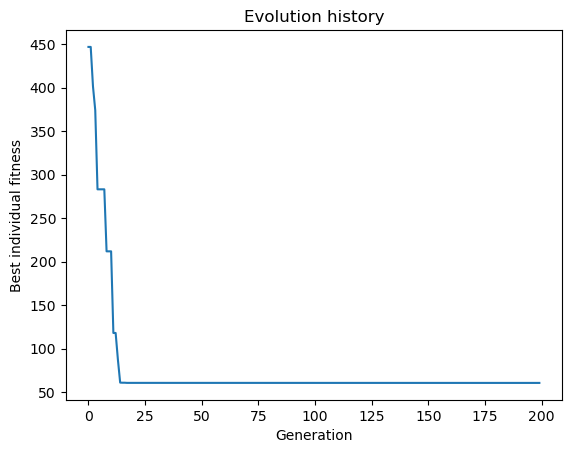

In [345]:
res_mpg2['history'].plot_history()

#### 7, 5, 5, 1

In [346]:
ae = EvoAlg(X=mpg_X, y=mpg_y, layers=[7,5,5,1], model_type='regression', resize=False, population_size=30, generations=150)
res_mpg3 = ae.train()

C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\2194875051.py:71: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D5083E7450>, fitness: 447.47094120265655
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D5083A2A10>, fitness: 346.8141280331396
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D50851DD10>, fitness: 155.2188967220308
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D5085269D0>, fitness: 67.97420479231218
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D50850DA50>, fitness: 60.7651270823155
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D50850DA50>, fitness: 60.7651270823155
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D50850DA50>, fitness: 60.7651270823155
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D50850DA50>, fitness: 60.7651270823155
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D50850DA50>, fitne

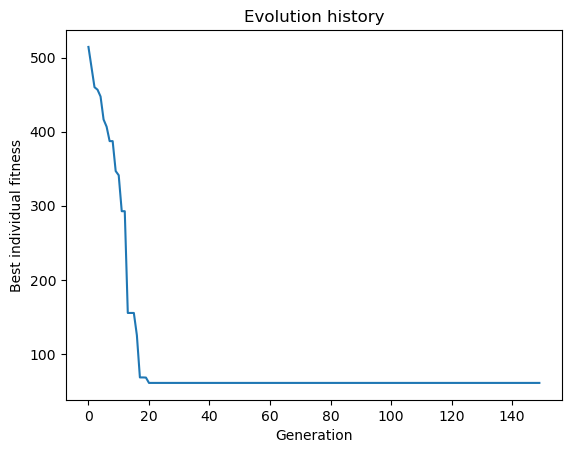

In [432]:
res_mpg3['history'].plot_history()

In [347]:
tests = [60.762747901279866, 60.76340191873822, 60.76273974842511]
print(np.mean(tests))
print(np.std(tests))

60.76296318948106
0.00031024628718859807


#### standardize data

In [376]:
mpg = auto_mpg.data.features.copy()
mpg_y = auto_mpg.data.targets.copy()
mpg['y'] = mpg_y['mpg']
mpg.dropna(inplace=True)
mpg_X = mpg.drop(['y'], axis=1)
mpg_y = mpg['y'].to_numpy()

mpg_X_std, mpg_params = standardize_data(mpg_X)
mpg_X = mpg_X_std.to_numpy()

In [378]:
ae = EvoAlg(X=mpg_X, y=mpg_y, layers=[7,5,1], model_type='regression', resize=False, population_size=50, generations=50)
mpg_ch = ae.train(mutation_rate=0.9, crossover_rate=0.9)

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D508DF9E10>, fitness: 237.36753599083656
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D506BBF8D0>, fitness: 65.92724962850122
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D506BBF8D0>, fitness: 65.92724962850122
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D506BBF8D0>, fitness: 65.92724962850122
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D508D27310>, fitness: 64.83143808481425
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D50839BE90>, fitness: 64.61766603216263
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D5085A41D0>, fitness: 63.283370152923794
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D506BF1250>, fitness: 62.9230723358789
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D508350490>, f

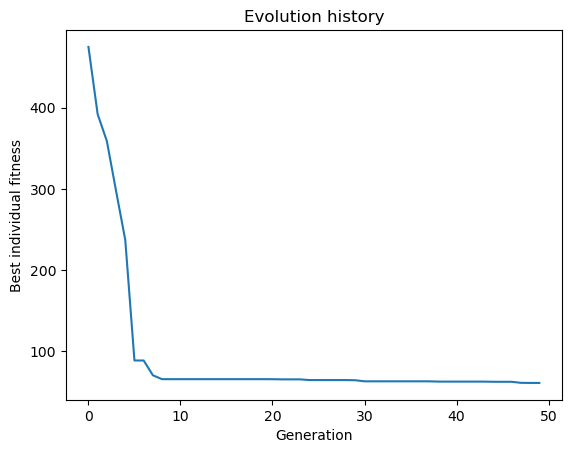

In [435]:
mpg_ch['history'].plot_history()

#### problem

In [350]:
mlp_mpg = res_mpg['best_individual']

In [381]:
# te same zwracane wartości:

In [355]:
mlp_mpg.predict(mlp_mpg.X)

C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\2194875051.py:71: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


array([[23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23.44899391],
       [23

In [382]:
# wagi wyglądają normalnie, nie ma sytuacji że wagi są zero i ostatni bias 23.448...

In [358]:
mlp_mpg.weights

[array([[  4.26983822,   1.00442684,  -3.66439079,   2.97483581,
           0.09116954],
        [ -3.52858813,  -0.69573533,   0.01993118,  -9.07669185,
          -0.10387834],
        [  2.55208127,  -6.75156046,  -2.69757553,   3.16018407,
          -2.73303108],
        [  0.18583843,  -3.35932364,  -5.70202576,   3.02033054,
          -1.25851918],
        [ -4.45781331,   0.56850901,  -4.13744381,  -6.22889472,
          -2.70209915],
        [ -1.31619104,   1.07890788,  -0.9938617 ,  -0.87024632,
           0.25577035],
        [  5.61123948, -11.31520015,  -4.72254709,   1.46532737,
          -0.74962753]]),
 array([[12.97464348],
        [-1.12549516],
        [ 4.08594494],
        [ 7.73463254],
        [ 3.61718844]])]

In [385]:
mlp_mpg.biases

[array([-8.14442487,  5.23345604,  0.85855401,  0.10756746,  2.73395204]),
 array([2.73971789])]

In [360]:
mlp_mpg.X

array([[307. ,   8. , 130. , ...,  12. ,  70. ,   1. ],
       [350. ,   8. , 165. , ...,  11.5,  70. ,   1. ],
       [318. ,   8. , 150. , ...,  11. ,  70. ,   1. ],
       ...,
       [135. ,   4. ,  84. , ...,  11.6,  82. ,   1. ],
       [120. ,   4. ,  79. , ...,  18.6,  82. ,   1. ],
       [119. ,   4. ,  82. , ...,  19.4,  82. ,   1. ]])

In [424]:
# tylko 2 i 3 kolumna mają wpływ (cylinders i horsepower) ale dla typowego zakresu tych wartości jest zwracane w zasadzie to samo

In [431]:
mlp_mpg.feedforward([0 ,   8,  3 , 0,  0,  0, 0])

array([2.74982809])

In [427]:
mpg_mlp = NeuralNetwork(layers=[7,5,1], X=mpg_X, y=mpg_y, model_type='regression', resize=False)

In [429]:
mpg_mlp.feedforward([119. ,   4. ,  82. , 100,  19.4,  82. ,   1. ])

array([-0.00774981])

#### modified selection, different params

In [439]:
ae = EvoAlg(X=mpg_X, y=mpg_y, layers=[7,5,1], model_type='regression', resize=False, population_size=50, generations=150)
res_final = ae.train(mutation_rate=1, crossover_rate=0.5)

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D509055750>, fitness: 393.219914414616
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D5090E1710>, fitness: 78.90129433740661
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D50912DD50>, fitness: 70.75441377695266
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D50912DD50>, fitness: 70.75441377695266
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D5090893D0>, fitness: 70.75441377695266
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D5090FA790>, fitness: 78.90129433740661
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D50907CA90>, fitness: 72.91838791727226
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D509046990>, fitness: 72.91838791727226
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D509011D90>, fit

C:\Users\tymek\AppData\Local\Temp\ipykernel_14308\2194875051.py:71: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Generation 95: best individual: <__main__.NeuralNetwork object at 0x000001D509360390>, fitness: 65.51483490578349
Generation 100: best individual: <__main__.NeuralNetwork object at 0x000001D509088850>, fitness: 67.90155145906418
Generation 105: best individual: <__main__.NeuralNetwork object at 0x000001D509055D50>, fitness: 68.07637027013139
Generation 110: best individual: <__main__.NeuralNetwork object at 0x000001D50962C5D0>, fitness: 65.03376969831974
Generation 115: best individual: <__main__.NeuralNetwork object at 0x000001D509422550>, fitness: 64.72220471585821
Generation 120: best individual: <__main__.NeuralNetwork object at 0x000001D50942D890>, fitness: 65.03376969831974
Generation 125: best individual: <__main__.NeuralNetwork object at 0x000001D5090FA0D0>, fitness: 64.9344762053493
Generation 130: best individual: <__main__.NeuralNetwork object at 0x000001D5096EB850>, fitness: 64.44365045801202
Generation 135: best individual: <__main__.NeuralNetwork object at 0x000001D5094FC

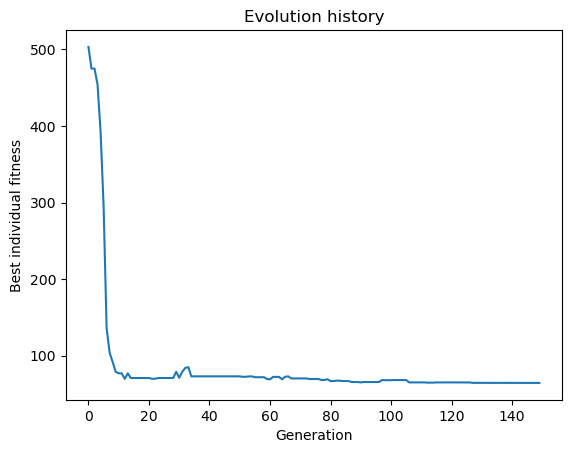

In [440]:
res_final['history'].plot_history()

#### modified mutation

In [457]:
# zamiast mutować wszystkie elementy rozwiązania, mutujemy tylko niektóre

In [458]:
ae = EvoAlg(X=mpg_X, y=mpg_y, layers=[7,5,1], model_type='regression', resize=False, population_size=50, generations=150)
res_mod = ae.train(mutation_rate=0.9, crossover_rate=0.5)

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D509A7B7D0>, fitness: 267.62099797220446
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D509EE8FD0>, fitness: 65.77054400453477
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D509ADC790>, fitness: 63.787677331684485
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D509B3CE90>, fitness: 62.34922875672137
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D509EC0C90>, fitness: 61.705987457399054
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D509B0A290>, fitness: 61.24179532382183
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D509DCFDD0>, fitness: 61.239921310202426
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D509AD8050>, fitness: 61.040488253948794
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D509817750

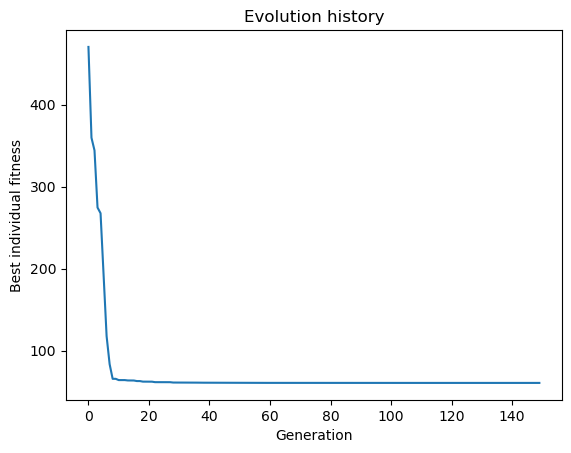

In [459]:
res_mod['history'].plot_history()

## Iris

In [444]:
iris = fetch_ucirepo(id=53) 

In [460]:
iris_X = iris.data.features.to_numpy()
iris_y = one_hot_encode(iris.data.targets)

In [527]:
def plot_iris(result):
    best_ir = result['best_individual']
    print('f1 score:', best_ir.loss(best_ir.X, best_ir.y, test=True))
    result['history'].plot_history()

### experiments

#### 4, 5, 3

In [515]:
ae = EvoAlg(X=iris_X, y=iris_y, layers=[4,5,3], model_type='classification', resize=False, population_size=30, generations=100)
# res_iris = ae.train()

In [516]:
res_iris = ae.train()

Generation 1: best individual: <__main__.NeuralNetwork object at 0x000001D508D48C10>, fitness: 0.9155322067680881
Generation 2: best individual: <__main__.NeuralNetwork object at 0x000001D5083CF610>, fitness: 0.8984465372430539
Generation 3: best individual: <__main__.NeuralNetwork object at 0x000001D508677550>, fitness: 0.8275602066709281
Generation 4: best individual: <__main__.NeuralNetwork object at 0x000001D508706D50>, fitness: 0.7970759727876362
Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D50866E010>, fitness: 0.6952099798542164
Generation 6: best individual: <__main__.NeuralNetwork object at 0x000001D5085BCCD0>, fitness: 0.6367627273114681
Generation 7: best individual: <__main__.NeuralNetwork object at 0x000001D5085BCCD0>, fitness: 0.6367627273114681
Generation 8: best individual: <__main__.NeuralNetwork object at 0x000001D5085BCCD0>, fitness: 0.6367627273114681
Generation 9: best individual: <__main__.NeuralNetwork object at 0x000001D5085E5CD0>, fi

f1 score: 0.9799819837854068


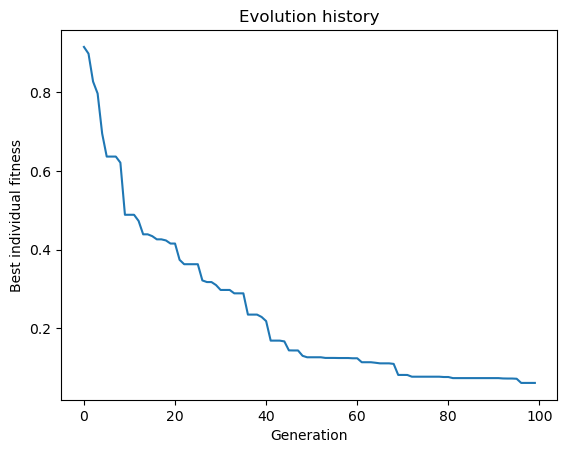

In [525]:
plot_iris(res_iris)

#### more generations

In [522]:
ae = EvoAlg(X=iris_X, y=iris_y, layers=[4,5,3], model_type='classification', resize=False, population_size=30, generations=150)
iris_150 = ae.train()

Generation 5: best individual: <__main__.NeuralNetwork object at 0x000001D506C96B10>, fitness: 1.0143969930600265
Generation 10: best individual: <__main__.NeuralNetwork object at 0x000001D50913F350>, fitness: 0.7339547045355506
Generation 15: best individual: <__main__.NeuralNetwork object at 0x000001D509181810>, fitness: 0.568073773450488
Generation 20: best individual: <__main__.NeuralNetwork object at 0x000001D506C7BE50>, fitness: 0.4982604414215363
Generation 25: best individual: <__main__.NeuralNetwork object at 0x000001D50772A450>, fitness: 0.40614725824472486
Generation 30: best individual: <__main__.NeuralNetwork object at 0x000001D5090F64D0>, fitness: 0.24800112984558226
Generation 35: best individual: <__main__.NeuralNetwork object at 0x000001D503469DD0>, fitness: 0.2480011298455822
Generation 40: best individual: <__main__.NeuralNetwork object at 0x000001D509133F10>, fitness: 0.1805966354194395
Generation 45: best individual: <__main__.NeuralNetwork object at 0x000001D50913

f1 score: 0.9733226623982927


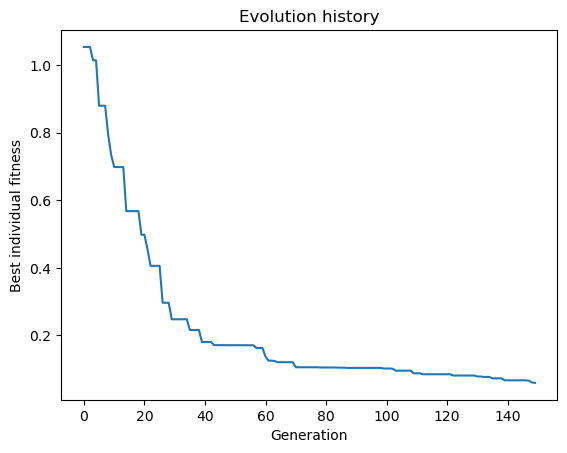

In [528]:
plot_iris(iris_150)

#### loop

In [529]:
fitness = []
for i in range(5):
    print('iteration:', i)
    ae = EvoAlg(X=iris_X, y=iris_y, layers=[4,5,3], model_type='classification', resize=False, population_size=30, generations=150)
    iris_i = ae.train(mute_print=True)
    fitness.append(iris_i['best_individual'].loss(best_ir.X, best_ir.y, test=True))

print(np.mean(fitness))
print(np.std(fitness))

iteration: 0
Best individual: <__main__.NeuralNetwork object at 0x000001D508913C10>, fitness: 0.08416842641424704
iteration: 1
Best individual: <__main__.NeuralNetwork object at 0x000001D5089165D0>, fitness: 0.06462042609950938
iteration: 2
Best individual: <__main__.NeuralNetwork object at 0x000001D5085BF690>, fitness: 0.0631524322261001
iteration: 3
Best individual: <__main__.NeuralNetwork object at 0x000001D50C1BF3D0>, fitness: 0.08404400905166184
iteration: 4
Best individual: <__main__.NeuralNetwork object at 0x000001D50C4E9010>, fitness: 0.11341702250893741
0.9693283985461371
0.010835401455197426
